## Explainable Evidential Clustering

In [10]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [11]:
# Load the csv file
df = pd.read_csv('data/easy_synth_data.csv')

feature_names = df.columns[:-1].to_list()
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
classes = np.unique(labels)

## Evidential C-Means Clustering

In [12]:
number_clusters = 2

# ECM clustering
from evclust.ecm import ecm
model = ecm(x=features, c=number_clusters, beta = 1.3,  alpha=1, delta=3, disp=False)

/var/folders/qn/sypqqw3101v1k6_70wqyd99h0000gn/T/ipykernel_24363/639970195.py:22: RuntimeWarning: invalid value encountered in divide
  color = color/np.sum(f)


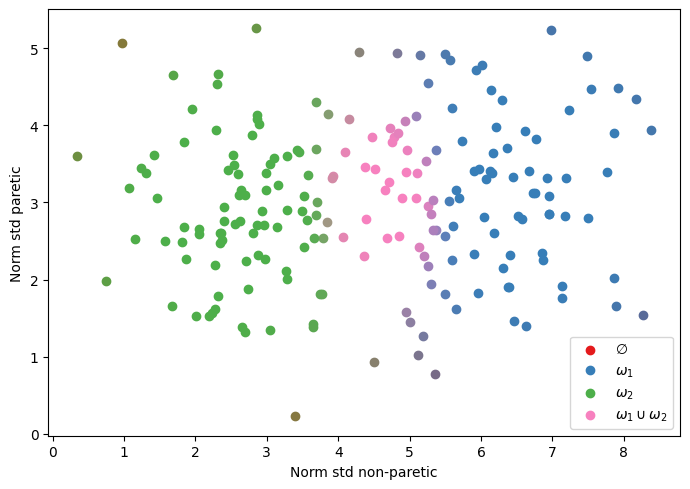

In [74]:
def plot_ecm(model, cmap='Set1'):
    F = model['F']
    mass = model['mass']
    number_clusters = int(np.log2(mass.shape[1]))

    focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
    focal_sets[0] = "\emptyset"
    mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(len(focal_sets))]
    focal_sets = ['$'+f+'$' for f in focal_sets]

    cmap = plt.get_cmap(cmap)

    cluster_base_colors = [np.array(cmap(0)), np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]
        
    focal_colors = []

    for f in F:
        color = np.array([0., 0., 0., 0.])
        for i in range(len(f)):
            if f[i] == 1:
                color += cluster_base_colors[i+1]
        color = color/np.sum(f)

        cardinality_indication_color = np.array(cmap(7)) #np.array([0., 0., 0., 1.])

        color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

        focal_colors.append(color)
    focal_colors[0] = cluster_base_colors[0]

    colors = []
    for point in range(len(features)):
        color = np.sum([focal_colors[i] * mass[point, i] for i in range(len(focal_sets))], axis=0)
        color = np.clip(color, 0, 1)
        color = color[:3]
        colors.append(color)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    for i in range(len(features)):
        ax.scatter(features[i, 0], features[i, 1], color=colors[i])

    for i in range(len(focal_sets)):
        ax.scatter([], [], color=focal_colors[i], label=focal_sets[i])

    ax.legend(loc='lower right')

    ax.set_xlabel('Norm std non-paretic')
    ax.set_ylabel('Norm std paretic')

    # tight
    plt.tight_layout()

    # savefig
    #plt.savefig('figs/evidential_clustering_reference.pdf')

    plt.show()

    return fig, ax, colors, focal_colors, mass_focal_sets, focal_sets

fig, ax, colors, focal_colors, mass_focal_sets, focal_sets = plot_ecm(model)

```
def plot_parameters(alpha, beta, delta, ax, name):
    model = ecm(x=features, c=2, beta = beta,  alpha=alpha, delta=delta, disp=False)
    F = model['F']
    mass = model['mass']

    focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
    focal_sets[0] = "\emptyset"
    mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(len(focal_sets))]
    focal_sets = ['$'+f+'$' for f in focal_sets]

    cmap = plt.get_cmap('Set1')

    cluster_base_colors = [np.array(cmap(0)), np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]
    focal_colors = []

    for f in F:
        color = np.array([0., 0., 0., 0.])
        for i in range(len(f)):
            if f[i] == 1:
                color += cluster_base_colors[i+1]
        color = color/np.sum(f)

        cardinality_indication_color = np.array(cmap(7))

        color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

        focal_colors.append(color)
    focal_colors[0] = cluster_base_colors[0]

    colors = []
    for point in range(len(features)):
        color = np.sum([focal_colors[i] * mass[point, i] for i in range(len(focal_sets))], axis=0)
        color = np.clip(color, 0, 1)
        color = color[:3]
        colors.append(color)

    for i in range(len(features)):
        ax.scatter(features[i, 0], features[i, 1], color=colors[i], edgecolors='black')

    for i in range(len(focal_sets)):
        ax.scatter([], [], color=focal_colors[i], label=focal_sets[i])

    #ax.legend(loc='lower right')

    ax.set_title(name)

    return focal_sets
```

````
fig, axs = plt.subplots(2, 3, figsize=(10, 6.66))

pars = [
    (10, 1.01, 10),
    (10, 2, 10),
    (10, 1.7, 3),
    (1, 1.01, 3),
    (1, 1.4, 3),
]

name = [
    '(quasi-)Hard Clustering',
    '(quasi-)Fuzzy Clustering',
    '(quasi-)Possibilistic Clustering',
    '(quasi-)Rough Clustering',
    'Evidential Clustering',
]

# scatter in gray
for point in range(len(features)):
    axs[0, 0].scatter(features[point, 0], features[point, 1], c='gray', edgecolors='k')
    axs[0, 0].set_yticks([])
    axs[0, 0].set_xticks([])
    axs[0, 0].set_title('Original Data Distribution')

for i in range(len(pars)):
    i +=1
    focal_sets = plot_parameters(*pars[i-1], axs[i//3, i%3], name[i-1])

fig.suptitle('ECM Clustering Output ($C=2$, $X \in \mathbb{R}^2$) with different parameters', fontsize=14)

fig.tight_layout()

fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], 
                                    markerfacecolor=plt.get_cmap('Set1')(i), markersize=10) for i in range(len(focal_sets))],edgecolor='black', 
                loc='lower center', ncol=len(focal_sets), fontsize='large', title='meta-clusters ($F = 2^\Omega$)', bbox_to_anchor=(0.5, -0.1))
        

# export the plot as a pdf
#plt.savefig('figs/ECM_clustering.pdf', bbox_inches='tight')
````

In [75]:
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

In [76]:
mass = model['mass']
F = model['F']

pl = np.matmul(mass, F)

metacluster_cardinality = np.sum(F, axis=1)
bel = mass[:, metacluster_cardinality == 1]

most_plausible_cluster = np.argmax(bel, axis=1)

## XEDTs

In [224]:
%load_ext autoreload
%autoreload 2

from lib.xedt import XEDT

def create_edt(features_tree_generator = lambda x: x, edt_pars={}, plot_tree_pars={}, export_name=None):
    classifier = XEDT(**edt_pars)

    features_tree = features_tree_generator(features)

    y = mass.copy()

    classifier.fit(features_tree, y, F)

    diagram = classifier.plot_tree(**plot_tree_pars)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    features_xy = np.column_stack((X.ravel(), Y.ravel()))
    Z = classifier.predict(features_xy).reshape(X.shape)

    k = lambda j: [i for i in range(len(F)) if F[i, j] == 1 and np.sum(F[i]) == 1][0]

    Z_mass = classifier.predict(features_xy, return_bba=True)[1].reshape(X.shape[0], X.shape[1], -1)

    Z_color = np.zeros((X.shape[0], X.shape[1], 3))
    for k in range(len(F)):
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z_color[i, j] += Z_mass[i, j, k] * focal_colors[k][:3]

    ax.scatter(X, Y, c=Z_color.reshape(-1, 3))
    ax.title.set_text('Prediction')

    # scatter the data
    for i in range(len(features)):
        ax.scatter(features[i, 0], features[i, 1], color=colors[i], edgecolors='black')

    if export_name is not None:
        plt.tight_layout()
        plt.savefig('figs/' + export_name + '_space.pdf')
        diagram.save('figs/' + export_name + '_tree.pdf')


    plt.show()

    cluster_names = ['\\omega_{' + str(i) + '}' for i in range(len(F))]
    paths = classifier.get_path(['x', 'y'], cluster_names=cluster_names)
    for i in range(len(paths)):
        path = paths[i]
        # path is a dict with only one key
        key = list(path.keys())[0]
        path = path[key]
        path = ' and '.join(path)
        print(f"Explanation for {key}: {path}")

    return diagram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


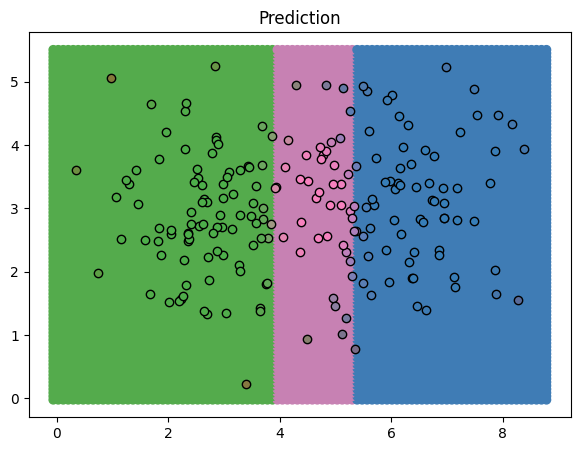

Explanation for \omega_{2}: x ≤ 3.88
Explanation for \omega_{3}: x > 3.88 and x ≤ 5.34
Explanation for \omega_{1}: x > 3.88 and x > 5.34


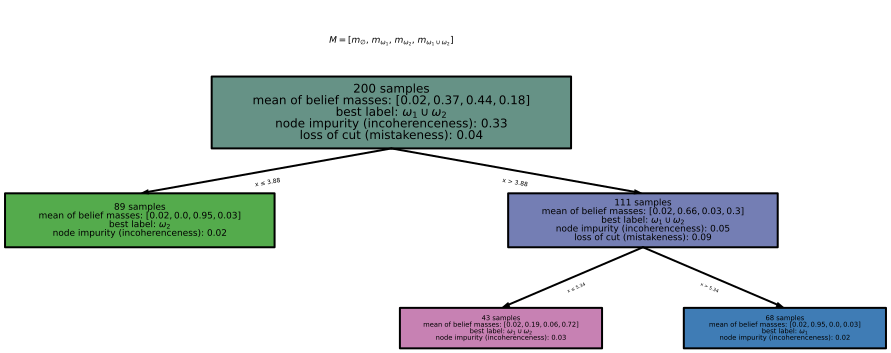

In [227]:
create_edt(
    edt_pars={
        'lambda_mistakeness' : np.inf
    },
    plot_tree_pars={
        'class_names' : mass_focal_sets,
        'focal_colors' : np.array(focal_colors),
        'cluster_names' : ['\\omega_{' + str(i) + '}' for i in range(len(F))],
        'feature_names' : ['x', 'y']
    }
)